In [ ]:
!pip install gym==0.15.3
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 24.1 MB/s 
     |████████████████████████████████| 1.0 MB 54.1 MB/s 
  Created wheel for gym: filename=gym-0.15.3-py3-none-any.whl size=1644970 sha256=3f947b2326c2edc78c89047d7bb8f90e99e3201012be1ba09f9d8c8c36c5f0f0
  Stored in directory: /root/.cache/pip/wheels/55/16/6b/2250ca4f9f050a4d27d8bed287e57bbb3c33fc4066f557cc75
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.5.0
    Uninstalling cloudpickle-1.5.0:
      Successfully uninstalled cloudpickle-1.5.0
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probabi

In [ ]:

from torch import nn
import random
import torch
import numpy as np

import gym
from gym.wrappers import Monitor

import sys
import glob
import io
import base64
import os

import matplotlib.pyplot as plt
# import hiplot as hip
import plotly.express as px
import cv2

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

from tqdm.notebook import tqdm
from collections import deque 

%matplotlib inline


In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Selected Device : {device}')

device = 'cpu'

In [ ]:
def show_videos():
    mp4list = glob.glob('video/*.mp4')
    mp4list.sort()
    for mp4 in mp4list:
        print(f"\nSHOWING VIDEO {mp4}")
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
    env = Monitor(env, './video', force=True, video_callable=video_callable)
    return env



In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) )

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples 
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory) 

In [ ]:
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(5, 5, 5, 5), (4, 4, 4, 4)]
[(5, 5, 5, 5), (4, 4, 4, 4)]
[(5, 5, 5, 5), (3, 3, 3, 3)]
[(5, 5, 5, 5), (4, 4, 4, 4)]
[(3, 3, 3, 3), (5, 5, 5, 5)]


In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)


In [ ]:
net = DQN(state_space_dim=4, action_space_dim=2)
print(net)

DQN(
  (linear): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    best_action = int(net_out.argmax())
    action_space_dim = net_out.shape[-1]

    if random.random() < epsilon:
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        action = random.choice(non_optimal_actions)
    else:
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0
Q-VALUES: [0.25055712 0.01303197]


In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    temperature = max(temperature, 1e-8) 
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0
Q-VALUES: [0.25055712 0.01303197]


In [ ]:
def expl_profile_softmax(num_iterations, initial_value):

    if initial_value == 1:
        exploration_profile = np.array([np.exp(-i / num_iterations * 6 ) for i in range(num_iterations)])
    else:    
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
        exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])

    return exploration_profile

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

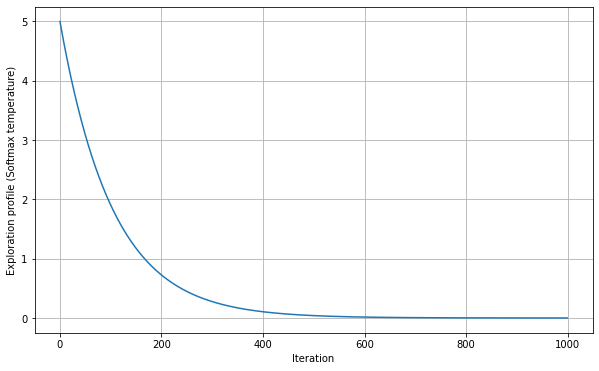

In [ ]:
initial_value = 5
num_iterations = 1000

exploration_profile = expl_profile_softmax(num_iterations,initial_value)

### Plot exploration profile
plt.figure(figsize=(10,6))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0) 
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2
ACTION SPACE SIZE: 2


In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0) 

env = wrap_env(env, video_callable=lambda episode_id: True)

for num_episode in range(10): 
    state = env.reset()
    score = 0
    done = False
    while not done and score < 490:
      action = random.choice([0, 1])
      next_state, reward, done, info = env.step(action)
      env.render()
      score += reward 
      state = next_state
      # Check if the episode ended (the pole fell down)

    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()

EPISODE 1 - FINAL SCORE: 11.0
EPISODE 2 - FINAL SCORE: 25.0
EPISODE 3 - FINAL SCORE: 10.0
EPISODE 4 - FINAL SCORE: 30.0
EPISODE 5 - FINAL SCORE: 25.0
EPISODE 6 - FINAL SCORE: 24.0
EPISODE 7 - FINAL SCORE: 23.0
EPISODE 8 - FINAL SCORE: 15.0
EPISODE 9 - FINAL SCORE: 26.0
EPISODE 10 - FINAL SCORE: 29.0


In [ ]:
# Display the videos, not required outside Colab
# show_videos()


SHOWING VIDEO video/openaigym.video.0.70.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.70.video000001.mp4



SHOWING VIDEO video/openaigym.video.0.70.video000002.mp4



SHOWING VIDEO video/openaigym.video.0.70.video000003.mp4



SHOWING VIDEO video/openaigym.video.0.70.video000004.mp4



SHOWING VIDEO video/openaigym.video.0.70.video000005.mp4



SHOWING VIDEO video/openaigym.video.0.70.video000006.mp4



SHOWING VIDEO video/openaigym.video.0.70.video000007.mp4



SHOWING VIDEO video/openaigym.video.0.70.video000008.mp4



SHOWING VIDEO video/openaigym.video.0.70.video000009.mp4


In [ ]:
def initialize(params, replay_memory_capacity=10000, state_space_dim=4, action_space_dim=2):
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    # Copy the weights of the policy network to the target network
    target_net.load_state_dict(policy_net.state_dict()) 
    
    ### Initialize the optimizer
    # The optimizer will update ONLY the parameters of the policy network
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=params['learning_rate']) 
    
    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [ ]:
def update_step(policy_net, target_net, replay_mem, optimizer, loss_fn, params):
    
    gamma = params['gamma']
    batch_size = params['batch_size']
    
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states  = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states 
    # (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) 
    # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    # Set the required tensor shape
    expected_state_action_values = expected_state_action_values.unsqueeze(1) 

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [ ]:
def train_loop(policy_net, target_net, replay_mem, exploration_profile, params):
    '''
    Function that defines the main training process
    '''

    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)
    
    # initialise output list containing all the scores
    scores = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # IMPLEMENT FURTHER PENALTY HERE
            off_cen_penalty = 1.
            reward = reward - off_cen_penalty * np.abs(state[0])

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > params['min_samples_for_training']: 
                # Enable the training only if there are enough samples in the replay memory
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, optimizer, loss_fn, params)

            # Visually render the environment 
            # comment to speed up the training
            # env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            # Copy the weights of the policy network to the target network  
            target_net.load_state_dict(policy_net.state_dict()) 
        
        # Save score
        scores.append(score)
    
    env.close()
    
    return policy_net, scores

In [ ]:


hyperparams = {'gamma': np.linspace(0.9, 0.99, 10),        
               'replay_memory_capacity': [10000],          
               'learning_rate': np.logspace(-3, -1, 10),   
               'target_net_update_steps': [5, 10, 15, 20], 
               'batch_size': [32, 64, 128, 256],           
               'bad_state_penalty': [0],                   
               'min_samples_for_training': [1000]          #
              }


In [ ]:
def random_params(params):
    selected_params = {}
    for i in params.keys():
        selected_params[i] = np.random.choice( params[i] )
    return selected_params

print(random_params(hyperparams))

{'gamma': 0.9, 'replay_memory_capacity': 10000, 'learning_rate': 0.0027825594022071257, 'target_net_update_steps': 10, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000}


In [ ]:

env = gym.make('CartPole-v1') 
env.seed(0) 
all_params = []
all_train_scores = []

for net in range(3):
    
    params = random_params(hyperparams)
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(params)
    policy_net, training_score = train_loop(policy_net, target_net, replay_mem, exploration_profile, params)
    
    all_params.append(params)
    all_train_scores.append(training_score)

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
for net, score in enumerate(np.array(all_train_scores)):
    
    mask = np.array(score) >= 490
    
    if score[mask].shape == (0,):
        all_params[net]['reach_490'] = 1000
    else:    
        all_params[net]['reach_490'] = np.where(mask)[0][0]

In [ ]:
all_params[0]

{'gamma': 0.97,
 'replay_memory_capacity': 10000,
 'learning_rate': 0.1,
 'target_net_update_steps': 5,
 'batch_size': 32,
 'bad_state_penalty': 0,
 'min_samples_for_training': 1000,
 'reach_490': 346}

In [ ]:
reach_490=np.zeros(len(all_params))

for i, param in enumerate(all_params):
    reach_490[i] = param['reach_490']
    
best_param = all_params[np.argmin(reach_490)]
best_param

{'gamma': 0.97,
 'replay_memory_capacity': 10000,
 'learning_rate': 0.1,
 'target_net_update_steps': 5,
 'batch_size': 32,
 'bad_state_penalty': 0,
 'min_samples_for_training': 1000,
 'reach_490': 346}

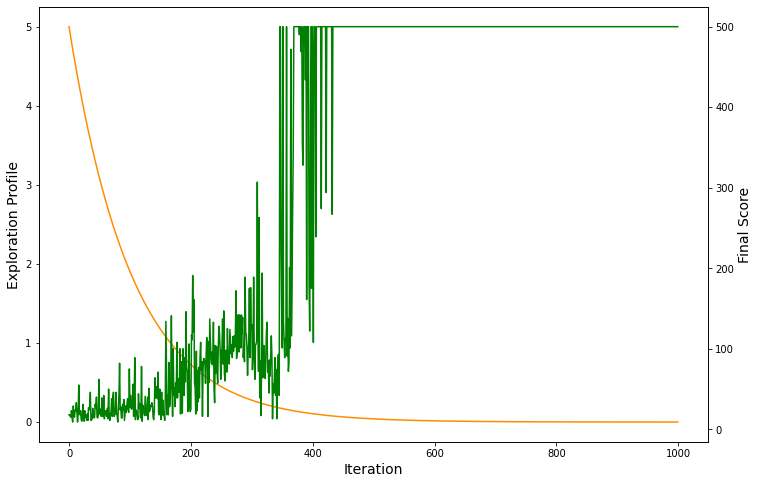

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(exploration_profile,color="darkorange")
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('Exploration Profile', fontsize=14)
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2.set_ylabel('Final Score', fontsize=14)
ax2.plot(all_train_scores[np.argmin(reach_490)],color="g")
ax2.tick_params(axis='y')
plt.show()

In [ ]:
best_param['min_samples_for_training']=1000
best_param['bad_state_penalty']=0
best_param['replay_memory_capacity']=10000

final_replay_mem, final_policy_net, final_target_net, optimizer, loss_fn = initialize(best_param) 


final_policy_net, final_training_score = train_loop(final_policy_net, final_target_net, final_replay_mem, 
                                                    exploration_profile, best_param)

torch.save(final_policy_net.state_dict(), 'final_cartpole')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0) 

final_policy_net.load_state_dict(torch.load('final_cartpole'))
final_policy_net.to(device)

env = wrap_env(env, video_callable=lambda episode_id: True) 

for num_episode in range(10): 
    state = env.reset()
    score = 0
    done = False
    while not done:
      action, q_values = choose_action_softmax(final_policy_net, state, temperature=0)
      next_state, reward, done, info = env.step(action)
      env.render()
      score += reward 
      state = next_state
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [ ]:
# Display the videos, not required outside Colab
# show_videos()

#Mountain Car

In [ ]:
env = gym.make('MountainCar-v0') 
env.seed(0) 

state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


In [ ]:
net = DQN(state_space_dim, action_space_dim)
print(net)

DQN(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)


In [ ]:
def expl_profile_softmax(num_iterations, initial_value):

    if initial_value == 1:
        exploration_profile = np.array([np.exp(-i / num_iterations * 6 ) for i in range(num_iterations)])
    else:    
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
        exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])

    return exploration_profile

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

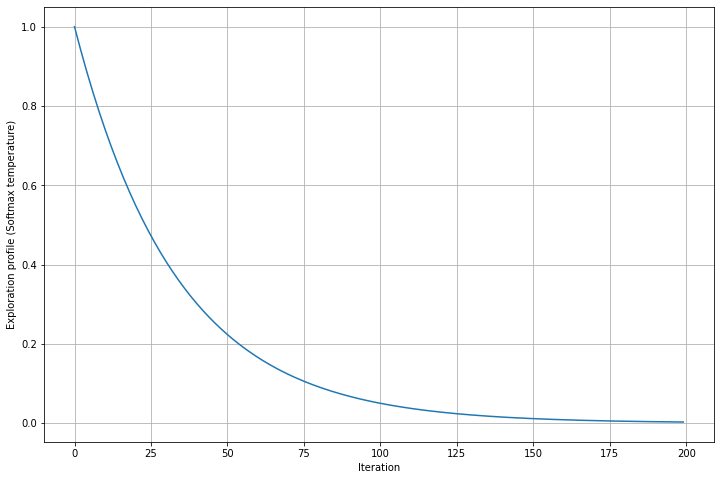

In [ ]:
initial_value = 1
num_iterations = 200

exploration_profile = expl_profile_softmax(num_iterations,initial_value)

plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [ ]:
state = (0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0
Q-VALUES: [-0.06603105  0.01235932  0.04115062]


In [ ]:
def train_loop_car(policy_net, target_net, replay_mem, exploration_profile, params):

    env = gym.make('MountainCar-v0') 
    
    max_positions = []
    scores = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        state = env.reset()

        score = 0
        done = False
        max_position = state[0]

        while not done:

            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            next_state, reward, done, info = env.step(action)
            
      
            if next_state[0] - state[0] > 0 and action == 2: reward += 1
            if next_state[0] - state[0] < 0 and action == 0: reward += 1  
            if next_state[0] >=0.5 : reward += 1 
                
        
            score += reward

            if next_state[0] > max_position:
                max_position = next_state[0]
                
            if done:
                reward += params['bad_state_penalty']
                next_state = None

            replay_mem.push(state, action, next_state, reward)

            if len(replay_mem) > params['min_samples_for_training']: 

                update_step(policy_net, target_net, replay_mem, optimizer, loss_fn, params)


            env.render()

            state = next_state

        if episode_num % params['target_net_update_steps'] == 0:
            target_net.load_state_dict(policy_net.state_dict()) 

        print(f"EPISODE: {episode_num + 1} - Max Position: {max_position} - Score: {score} - Temperature: {tau}") # Print the final score
        max_positions.append(max_position)
        scores.append(score)
    
    env.close()
    
    return policy_net, max_positions, scores
    

In [ ]:

car_params = {'gamma': 0.95,                   
              'replay_memory_capacity': 10000,
              'batch_size': 32,                
              'bad_state_penalty': 0,           
              'min_samples_for_training': 1000  
              'learning_rate': 0.1,            
              'target_net_update_steps': 5,    

             }

In [ ]:

replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(car_params, action_space_dim=action_space_dim, state_space_dim=state_space_dim)
policy_net, positions, training_score = train_loop_car(policy_net, target_net, replay_mem, exploration_profile, car_params)

  0%|          | 0/200 [00:00<?, ?it/s]

EPISODE: 1 - Max Position: -0.41454615434918646 - Score: -140.0 - Temperature: 1.0
EPISODE: 2 - Max Position: -0.24973628995684966 - Score: -133.0 - Temperature: 0.9704455335485082
EPISODE: 3 - Max Position: -0.411313600539505 - Score: -134.0 - Temperature: 0.9417645335842487
EPISODE: 4 - Max Position: -0.43937374814953745 - Score: -136.0 - Temperature: 0.9139311852712282
EPISODE: 5 - Max Position: -0.41874988200246865 - Score: -141.0 - Temperature: 0.8869204367171575
EPISODE: 6 - Max Position: -0.44057221733069934 - Score: -111.0 - Temperature: 0.8607079764250578
EPISODE: 7 - Max Position: -0.37183185709171984 - Score: -110.0 - Temperature: 0.835270211411272
EPISODE: 8 - Max Position: -0.284235198342089 - Score: -105.0 - Temperature: 0.8105842459701871
EPISODE: 9 - Max Position: -0.3359969194728531 - Score: -112.0 - Temperature: 0.7866278610665535
EPISODE: 10 - Max Position: -0.4946025511052796 - Score: -102.0 - Temperature: 0.7633794943368531
EPISODE: 11 - Max Position: -0.2936597113

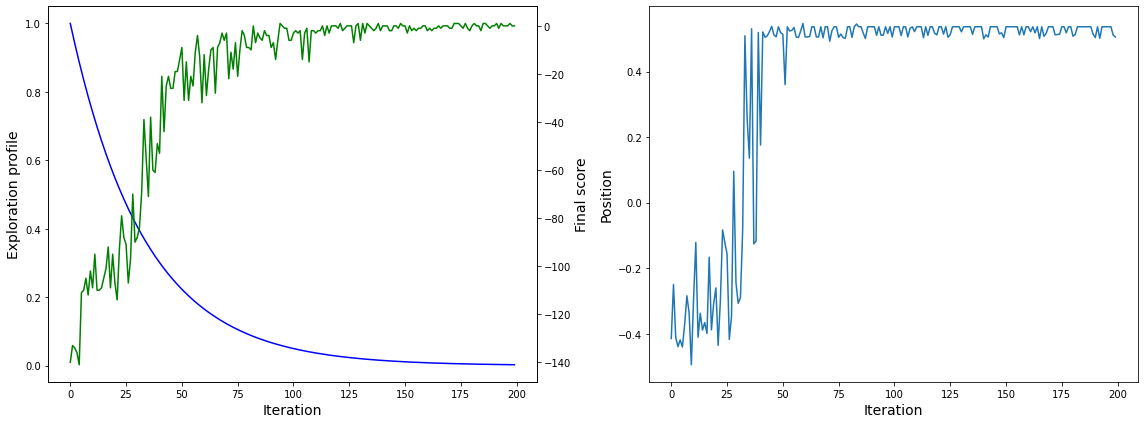

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_xlabel('Iteration', fontsize=14)
ax[0].set_ylabel('Exploration profile',  fontsize=14)
ax[0].plot(exploration_profile, color = 'b')
ax[0].tick_params(axis='y')

ax2 = ax[0].twinx() 

ax2.set_ylabel('Final score',  fontsize=14)
ax2.plot(training_score , color= 'green')
ax2.tick_params(axis='y')

ax[1].set_xlabel('Iteration', fontsize=14)
ax[1].set_ylabel('Position', fontsize=14)
ax[1].plot(positions)

fig.tight_layout()  
plt.show()

In [ ]:
torch.save(policy_net.state_dict(), 'mountain_car')

In [ ]:
env = gym.make('MountainCar-v0') 
env.seed(0) 

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = DQN(state_space_dim, action_space_dim)
net.to(device)

env = wrap_env(env, video_callable=lambda episode_id: True) 

for num_episode in range(10): 
    state = env.reset()
    done = False
    max_position = state[0]
    while not done:
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        next_state, reward, done, info = env.step(action)
        env.render()

        if next_state[0] > max_position:
            max_position = next_state[0]
            
        state = next_state

    print(f"EPISODE {num_episode + 1} - Max Position: {max_position}") 
env.close()

EPISODE 1 - Max Position: 0.5368577983788596
EPISODE 2 - Max Position: 0.5069096302184786
EPISODE 3 - Max Position: 0.5066299488695439
EPISODE 4 - Max Position: 0.5368577983788596
EPISODE 5 - Max Position: 0.5368577983788596
EPISODE 6 - Max Position: 0.5071724115628157
EPISODE 7 - Max Position: 0.5368577983788596
EPISODE 8 - Max Position: 0.5021542656542397
EPISODE 9 - Max Position: 0.5368577983788596
EPISODE 10 - Max Position: 0.5368577983788596
